# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import xticks
from nltk.corpus import stopwords
import nltk
import re
from nltk.stem import WordNetLemmatizer
import string
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import defaultdict
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
import tensorflow as tf
from sklearn.metrics import f1_score
from wordcloud import WordCloud,STOPWORDS
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from tensorflow.keras.preprocessing.sequence import pad_sequences
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding,Activation,Dropout
from keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D,LSTM

In [ ]:
# load train and test datasets
train=pd.read_csv('/content/train.csv', encoding='latin-1')
test=pd.read_csv('/content/test.csv')

In [ ]:
train.shape, test.shape

((7613, 5), (3263, 4))

In [ ]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train.isnull().sum().sort_values(ascending = False)

location    2533
keyword       61
id             0
text           0
target         0
dtype: int64

# **Exploratory Data Analysis**

In [ ]:
def draw_bar_plot(category,length,xlabel,ylabel,title,sub):
    plt.subplot(2,2,sub)
    plt.bar(category, length,color = 'grbkymc')
    plt.legend()
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.title(title, fontsize=15)

In [ ]:
def draw_hist(xlabel, ylabel,title,target,sub,color):
    plt.subplot(1,2,sub)
    plt.hist(train[train.target==target]["length"],color = color)
    plt.title(title,fontsize=25)
    plt.xlabel(xlabel,fontsize=15)
    plt.ylabel(ylabel,fontsize=15)
    plt.ylim(0,1200)
    plt.grid()

In [ ]:
def draw_bar_n_plot(data,title):
# lets visualize the top 10 stop words
    x,y=zip(*data)

    plt.figure(figsize = (25,10))
    plt.subplot(1,2,1)
    plt.bar(x,y,color='grbkymc')
    plt.title("Top 10 "+ title,fontsize=25)
    plt.xlabel(title,fontsize=15)
    plt.ylabel("Count",fontsize=15)
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(x,y,'g')
    plt.title("Top 10 "+ title,fontsize=25)
    plt.xlabel(title,fontsize=15)
    plt.ylabel("Count",fontsize=15)
    plt.grid()

In [ ]:
print("No. of Real Disaster Tweets (Target = 1):",len(train[train["target"]==1]))
print("No. of Fake Disaster Tweets (Target = 0):",len(train[train["target"]==0]))

No. of Real Disaster Tweets (Target = 1): 3271
No. of Fake Disaster Tweets (Target = 0): 4342


In [ ]:
##plt.figure(figsize = (12,8))
##draw_bar_plot(["Real","Fake"],[len(train[train.target==1]), len(train[train.target==0])],"Real Vs Fake","Number of Tweets","Class Distribution",1)

In [ ]:
def length(text):    
    return len(text)

train["length"]= train.text.apply(length)

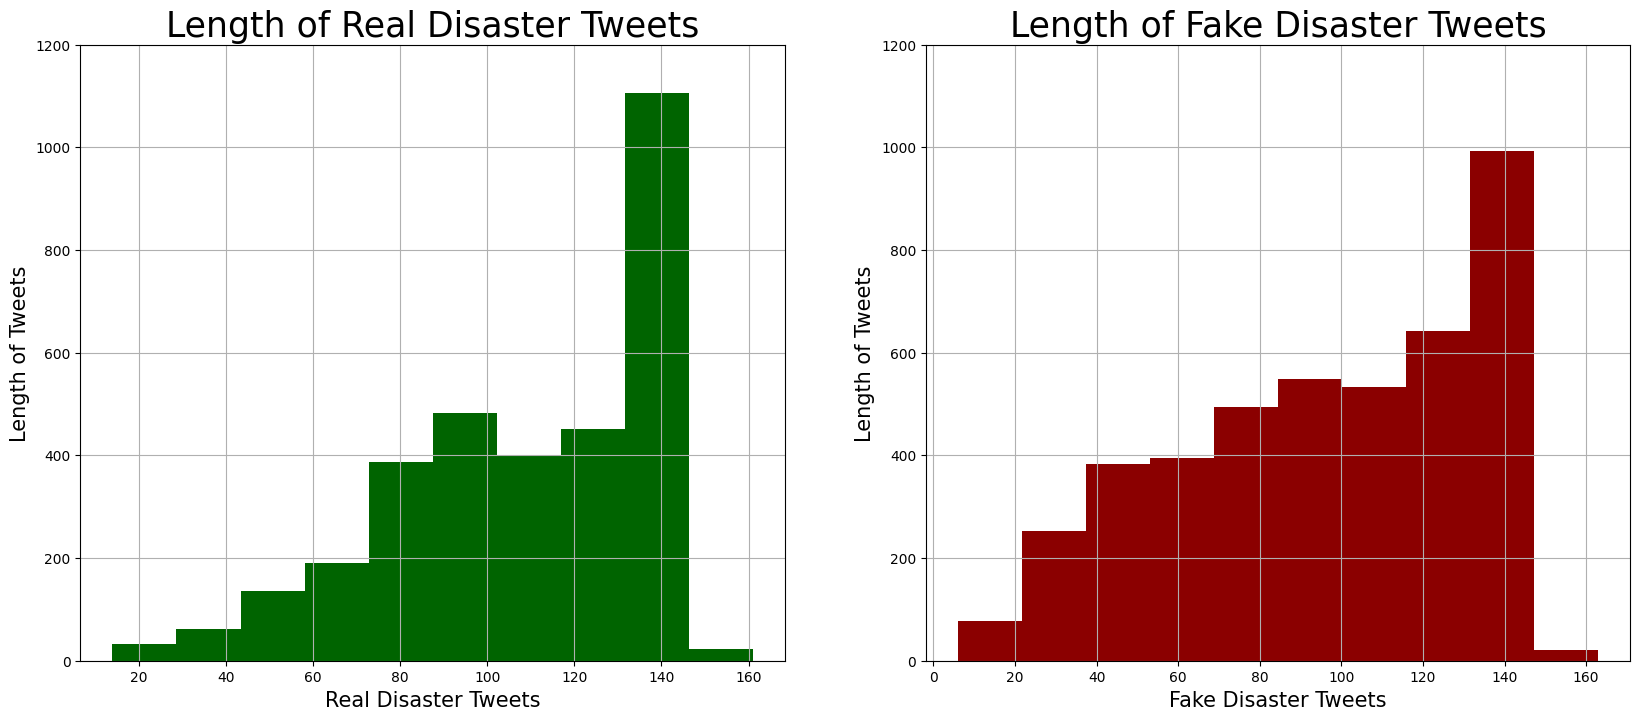

In [ ]:
plt.figure(figsize = (20,8))
draw_hist("Real Disaster Tweets","Length of Tweets","Length of Real Disaster Tweets",1, 1,"darkgreen")
draw_hist("Fake Disaster Tweets","Length of Tweets","Length of Fake Disaster Tweets",0, 2,"darkred")

target
1    108.444207
0     95.950023
Name: length, dtype: float64


<ipython-input-28-2c6dbc808fbc>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(train.groupby("target").mean()["length"].sort_values(ascending = False))
<ipython-input-28-2c6dbc808fbc>:6: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  draw_bar_plot(["Real","Fake"],[train[train.target==1].mean()["length"], train[train.target==0].mean()["length"]],"Real Vs Fake","Average Length","Average Text Length - Real Vs Fake",1)
<ipython-input-28-2c6dbc808fbc>:6: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will def

ValueError: ignored

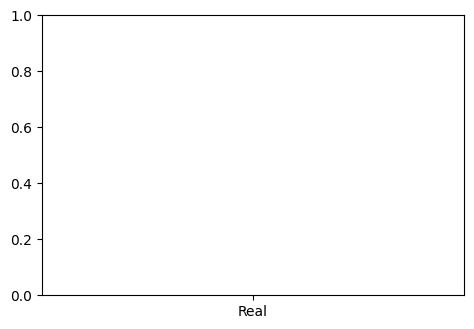

In [ ]:
# lets check the average lenght of real vs fake tweets
print(train.groupby("target").mean()["length"].sort_values(ascending = False))

# lets visualize the class distribution
plt.figure(figsize = (12,8))
draw_bar_plot(["Real","Fake"],[train[train.target==1].mean()["length"], train[train.target==0].mean()["length"]],"Real Vs Fake","Average Length","Average Text Length - Real Vs Fake",1)

# STOPWORDS & PUNCTUATIONS

In [ ]:
#lets save stopwords in a variable
import nltk
nltk.download('stopwords')
stop = list(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# stopwords present in the whole dataset
sw = []
for message in train.text:
    for word in message.split():
        if word in stop:
            sw.append(word)


# lets convert the list to a dictinoary which would contain the stop words and their frequency
wordlist = nltk.FreqDist(sw)
# lets save the 10 most frequent stopwords
top10 = wordlist.most_common(10)

ValueError: ignored

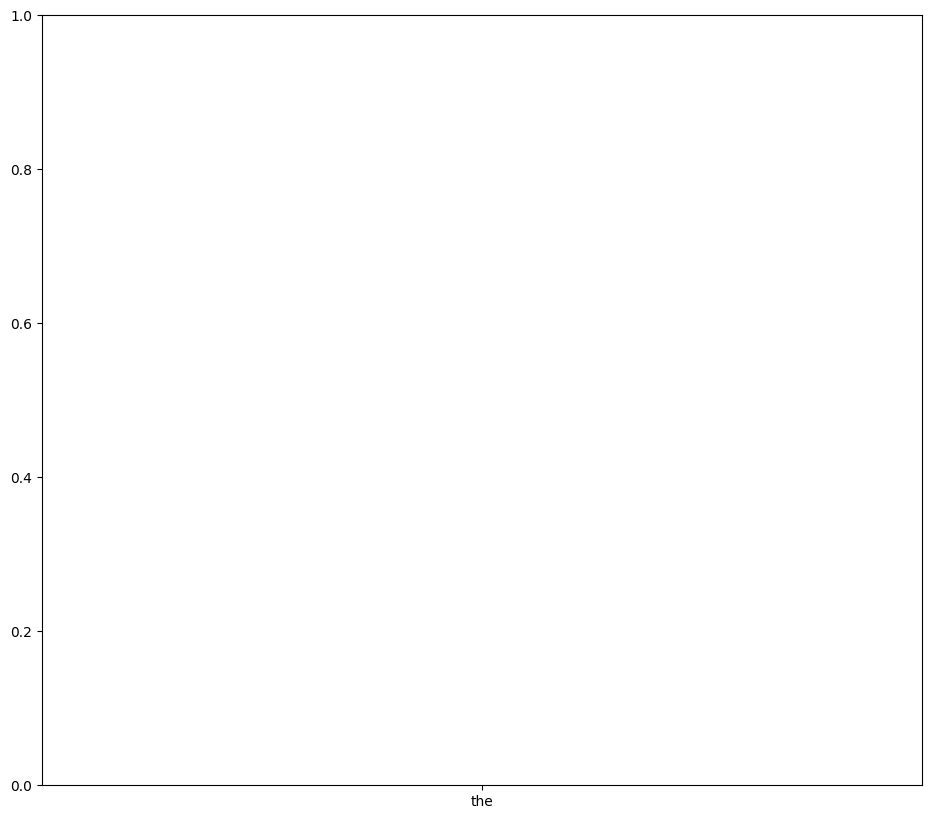

In [ ]:
draw_bar_n_plot(top10,"Stopwords")

Punctuations

In [ ]:
# save list of punctuation/special characters in a variable
punctuation = list(string.punctuation)

In [ ]:
# punctuations present in all the tweets 
pun = []
for message in train.text:
    for word in message.split():
        if word in punctuation:
            pun.append(word)


# lets convert the list to a dictinoary which would contain the punctuations and their frequency
wordlist = nltk.FreqDist(pun)
# lets save the 10 most frequent stopwords
top10 = wordlist.most_common(10)

In [ ]:
draw_bar_n_plot(top10,"Punctuations")

Stopwords & Punctuations

In [ ]:
# Let's check stop words and punctuations in "Real Disaster Tweets"
stop_real = []
pun_real  = []
for message in train[train.target==1]["text"]:
    for word in message.split():
        if word in stop:
            stop_real.append(word)
        if word in punctuation:
            pun_real.append(word)


# lets convert the list to a dictinoary which would contain the stop word and its frequency
stop_real_wordlist = nltk.FreqDist(stop_real)
pun_real_wordlist =  nltk.FreqDist(pun_real)

# lets save the 10 most frequent stopwords
stop_real_top10 = stop_real_wordlist.most_common(10)
pun_real_top10  = pun_real_wordlist.most_common(10)

In [ ]:
# Let's check "Fake Disaster Tweets" and create a list of stop words and punctuations
stop_fake = []
pun_fake  = []
for message in train[train.target==0]["text"]:
    for word in message.split():
        if word in stop:
            stop_fake.append(word)
        if word in punctuation:
            pun_fake.append(word)


# lets convert the list to a dictinoary which would contain the stop word and its frequency
stop_fake_wordlist = nltk.FreqDist(stop_fake)
pun_fake_wordlist =  nltk.FreqDist(pun_fake)

# lets save the 10 most frequent stopwords
stop_fake_top10 = stop_fake_wordlist.most_common(10)
pun_fake_top10  = pun_fake_wordlist.most_common(10)

In [ ]:
x_stop_real,y_stop_real=zip(*stop_real_top10)
x_pun_real, y_pun_real =zip(*pun_real_top10)

x_stop_fake,y_stop_fake=zip(*stop_fake_top10)
x_pun_fake, y_pun_fake=zip(*pun_fake_top10)


plt.figure(figsize = (30,30))
draw_bar_plot(x_stop_real,y_stop_real,"Stopwords","Count","Top 10 Stopwords - Real Tweets",1)
draw_bar_plot(x_stop_fake,y_stop_fake,"Stopwords","Count","Top 10 Stopwords - Fake Tweets",2)
draw_bar_plot(x_pun_real,y_pun_real,"Punctuations","Count","Top 10 Punctuations - Real Tweets",3)
draw_bar_plot(x_pun_fake,y_pun_fake,"Punctuations","Count","Top 10 Punctuations - Fake Tweets",4)

# DATA CLEANING

In [ ]:
lemma = WordNetLemmatizer()

In [ ]:
sw_pun = stop + punctuation

In [ ]:
# function to preprocess the messages
def preprocess(tweet):
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet) # removing urls 
    tweet = re.sub('[^\w]',' ',tweet) # remove embedded special characters in words (for example #earthquake)         
    tweet = re.sub('[\d]','',tweet) # this will remove numeric characters
    tweet = tweet.lower()
    words = tweet.split()  
    sentence = ""
    for word in words:     
        if word not in (sw_pun):  # removing stopwords & punctuations                
            word = lemma.lemmatize(word,pos = 'v')  # converting to lemma    
            if len(word) > 3: # we will consider words with length  greater than 3 only
                sentence = sentence + word + ' '             
    return(sentence)

In [ ]:
# function to preprocess the messages
def preprocess(tweet):
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet) # removing urls 
    tweet = re.sub('[^\w]',' ',tweet) # remove embedded special characters in words (for example #earthquake)         
    tweet = re.sub('[\d]','',tweet) # this will remove numeric characters
    tweet = tweet.lower()
    words = tweet.split()  
    sentence = ""
    for word in words:     
        if word not in (sw_pun):  # removing stopwords & punctuations                
            word = lemma.lemmatize(word,pos = 'v')  # converting to lemma    
            if len(word) > 3: # we will consider words with length  greater than 3 only
                sentence = sentence + word + ' '             
    return(sentence)

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
train['text'] = train['text'].apply(lambda s : preprocess(s))
test ['text'] = test ['text'].apply(lambda s : preprocess(s))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
# applying the function on the train and the test datasets
train['text'] = train['text'].apply(lambda s : remove_emoji(s))
test ['text'] = test ['text'].apply(lambda s : remove_emoji(s))

# Vocabulary creation

In [ ]:
from collections import Counter
def create_vocab(df):
    vocab = Counter()
    for i in range(df.shape[0]):
        vocab.update(df.text[i].split())
    return(vocab)

In [ ]:
# concatenate training and testing datasets
master=pd.concat((train,test)).reset_index(drop=True)

# call vocabulary creation function on master dataset
vocab = create_vocab(master)

# lets check the no. of words in the vocabulary
len(vocab)

16628

In [ ]:
vocab.most_common(50)

[('like', 560),
 ('fire', 532),
 ('bomb', 338),
 ('news', 300),
 ('people', 286),
 ('burn', 262),
 ('time', 253),
 ('kill', 252),
 ('make', 248),
 ('attack', 240),
 ('flood', 233),
 ('crash', 231),
 ('build', 230),
 ('emergency', 229),
 ('video', 228),
 ('come', 223),
 ('disaster', 219),
 ('take', 217),
 ('would', 214),
 ('body', 209),
 ('think', 204),
 ('police', 198),
 ('look', 193),
 ('know', 192),
 ('love', 191),
 ('watch', 188),
 ('home', 187),
 ('storm', 187),
 ('still', 181),
 ('train', 177),
 ('suicide', 177),
 ('live', 172),
 ('first', 169),
 ('collapse', 169),
 ('back', 164),
 ('scream', 164),
 ('california', 159),
 ('want', 156),
 ('drown', 152),
 ('cause', 151),
 ('need', 150),
 ('work', 149),
 ('today', 148),
 ('world', 148),
 ('nuclear', 148),
 ('hiroshima', 146),
 ('year', 143),
 ('service', 142),
 ('full', 142),
 ('destroy', 138)]

In [ ]:
final_vocab = []
min_occur = 2
for k,v in vocab.items():
    if v >= min_occur:
        final_vocab.append(k)

In [ ]:
len(final_vocab)

6039

In [ ]:
def filter(tweet):
    sentence = ""
    for word in tweet.split():  
        if word in final_vocab:
            sentence = sentence + word + ' '
    return(sentence)

In [ ]:
train['text'] = train['text'].apply(lambda s : filter(s))
test ['text'] = test ['text'].apply(lambda s : filter(s))

In [ ]:
# lets take a look at the update training dataset
train.text.head()

0               deeds reason earthquake allah forgive 
1                             forest fire near canada 
2    residents shelter place officer evacuation she...
3    people receive wildfires evacuation order cali...
4    send photo ruby alaska smoke wildfires pour sc...
Name: text, dtype: object

# N Gram Analysis

In [ ]:
# lets create seperate datasets from real and fake tweets
real = train[train.target==1].reset_index()
fake = train[train.target==0].reset_index()

In [ ]:
# function to create top 100 n-grams
def get_ngrams(data,n):
    all_words = []
    for i in range(len(data)):
        temp = data["text"][i].split()
        for word in temp:
            all_words.append(word)

    tokenized = all_words
    esBigrams = ngrams(tokenized, n)

    esBigram_wordlist = nltk.FreqDist(esBigrams)
    top100 = esBigram_wordlist.most_common(100)
    top100 = dict(top100)
    df_ngrams = pd.DataFrame(sorted(top100.items(), key=lambda x: x[1])[::-1])
    return df_ngrams

In [ ]:
def draw_barplots(real,fake,title):
    plt.figure(figsize = (40,80),dpi=100)

    plt.subplot(1,2,1)
    sns.barplot(y=real[0].values[:100], x=real[1].values[:100], color='green')
    plt.title("Top 100" + title + "in Real Tweets",fontsize=15)
    
    plt.subplot(1,2,2)
    sns.barplot(y=fake[0].values[:100], x=fake[1].values[:100],color='red')
    plt.title("Top 100" + title + "in Fake Tweets",fontsize=15)

Unigrams

In [ ]:
real_unigrams = get_ngrams(real,1)
fake_unigrams = get_ngrams(fake,1)

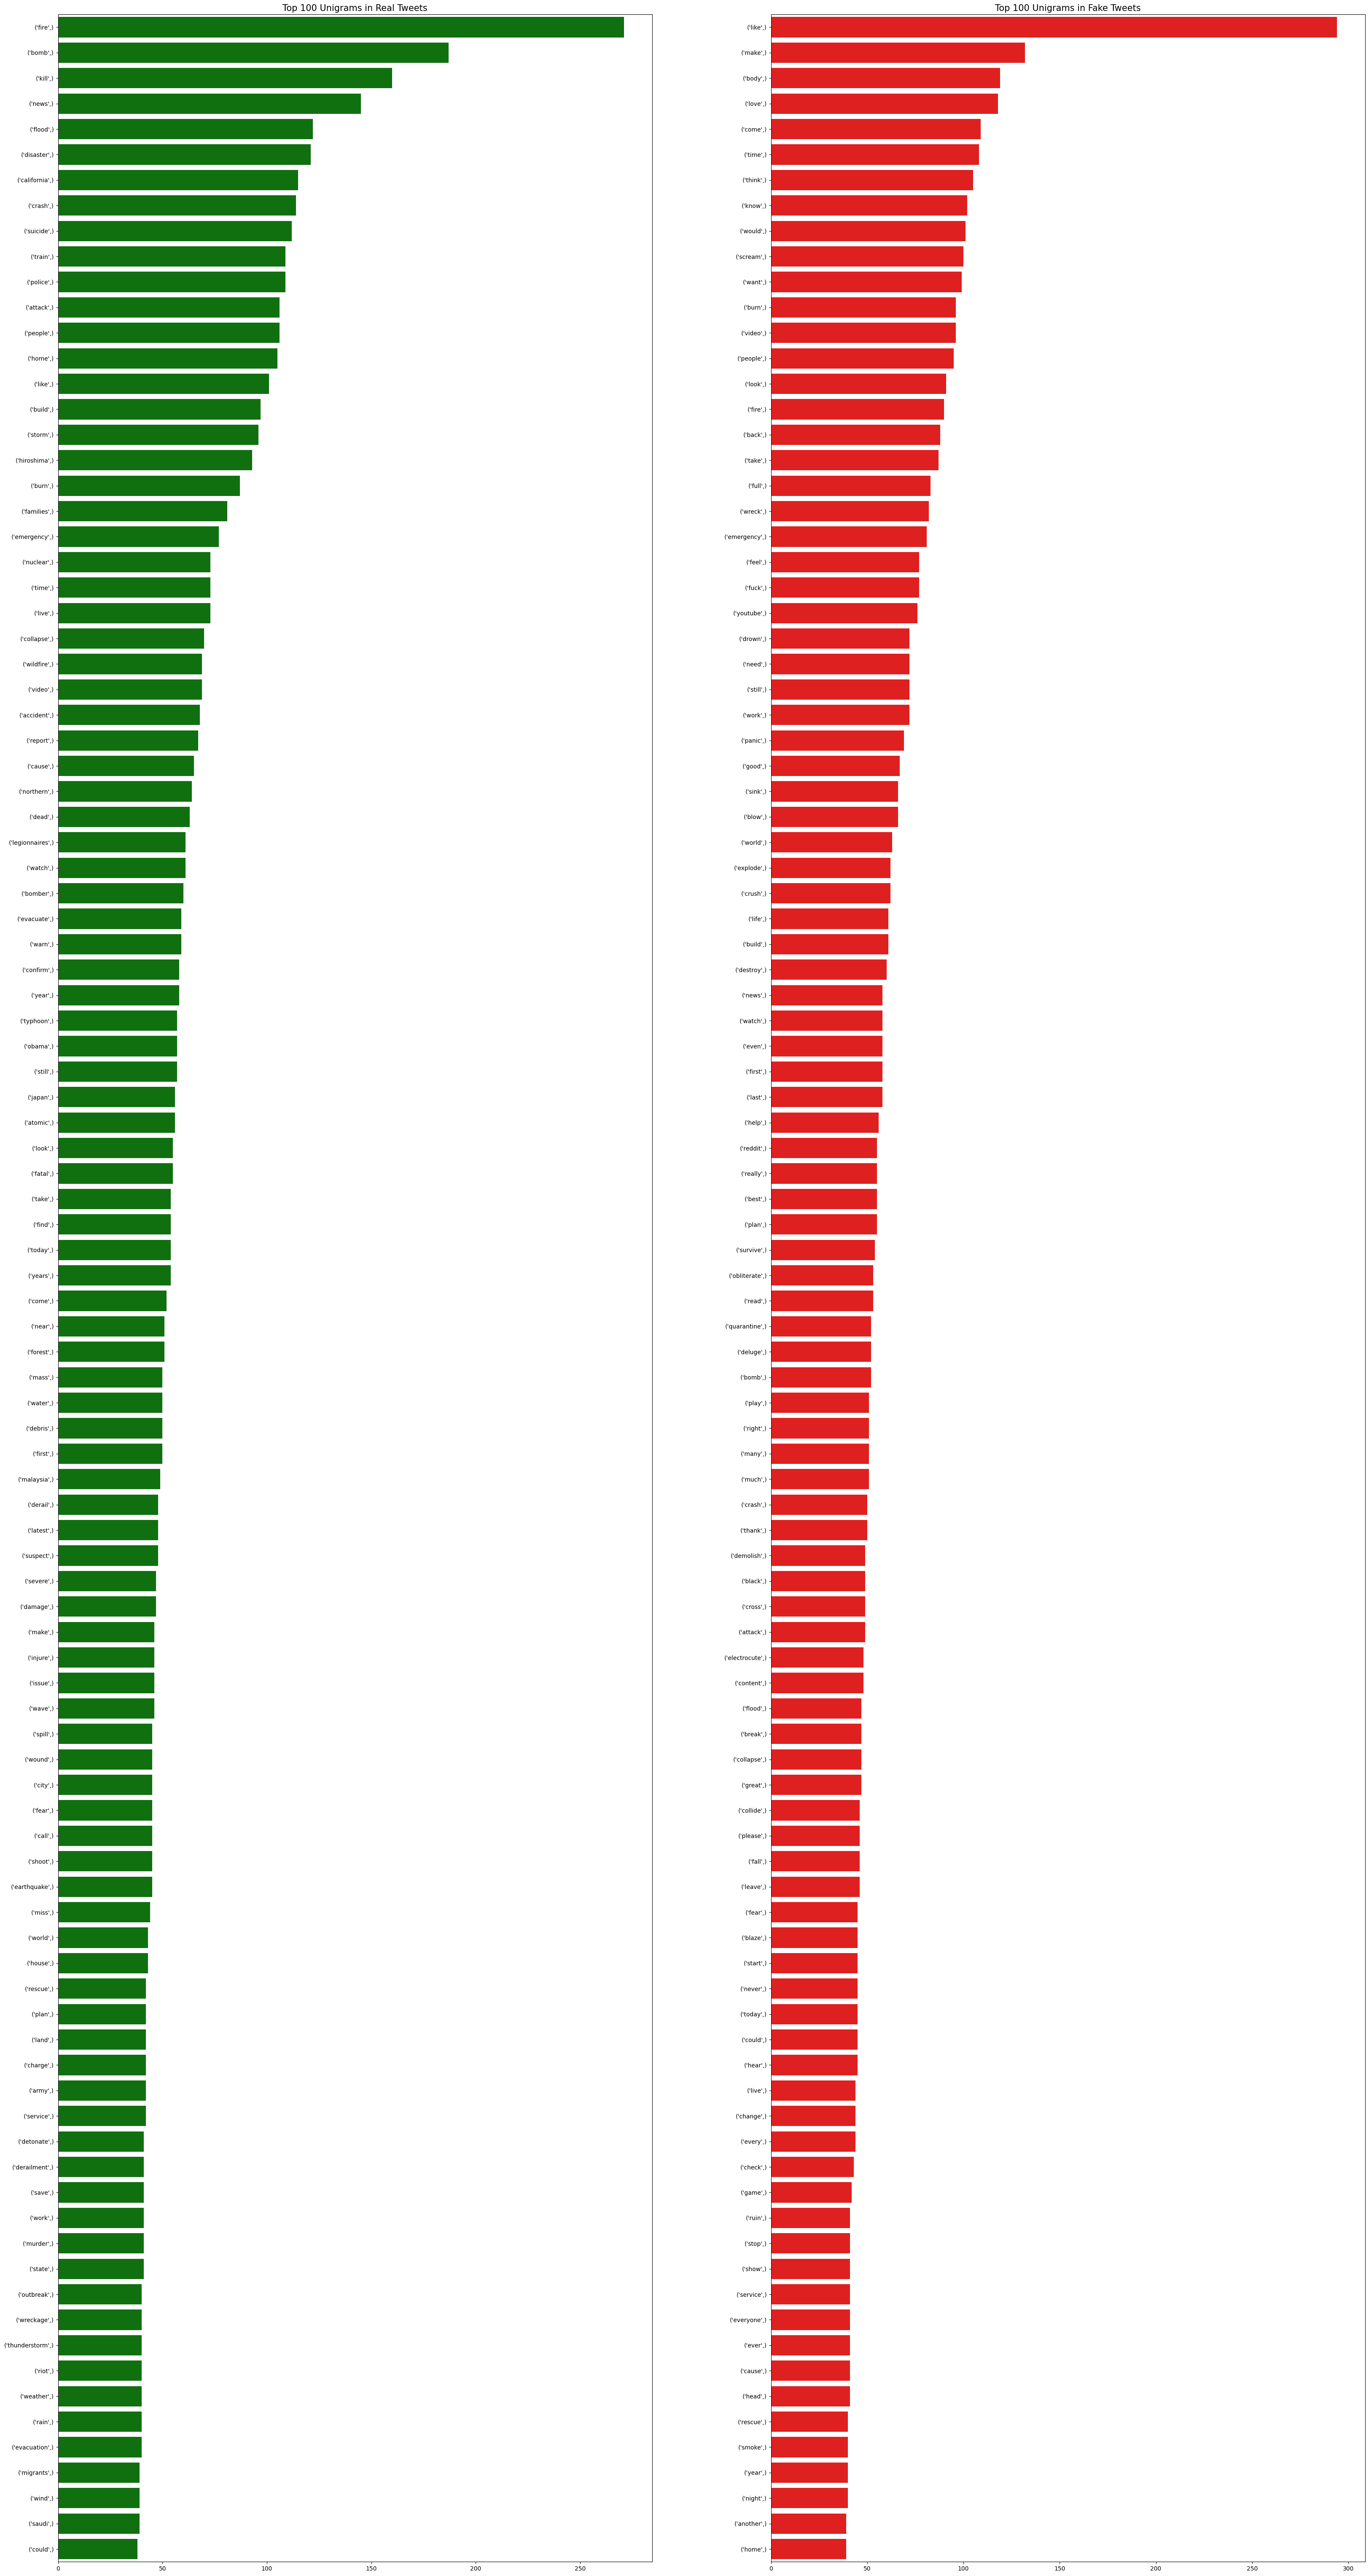

In [ ]:
# lets visualize top 100 unigrams
draw_barplots(real_unigrams,fake_unigrams," Unigrams ")

Bigrams

In [ ]:
# lets create top 100 bigrams
real_bigrams = get_ngrams(real,2)
fake_bigrams = get_ngrams(fake,2)

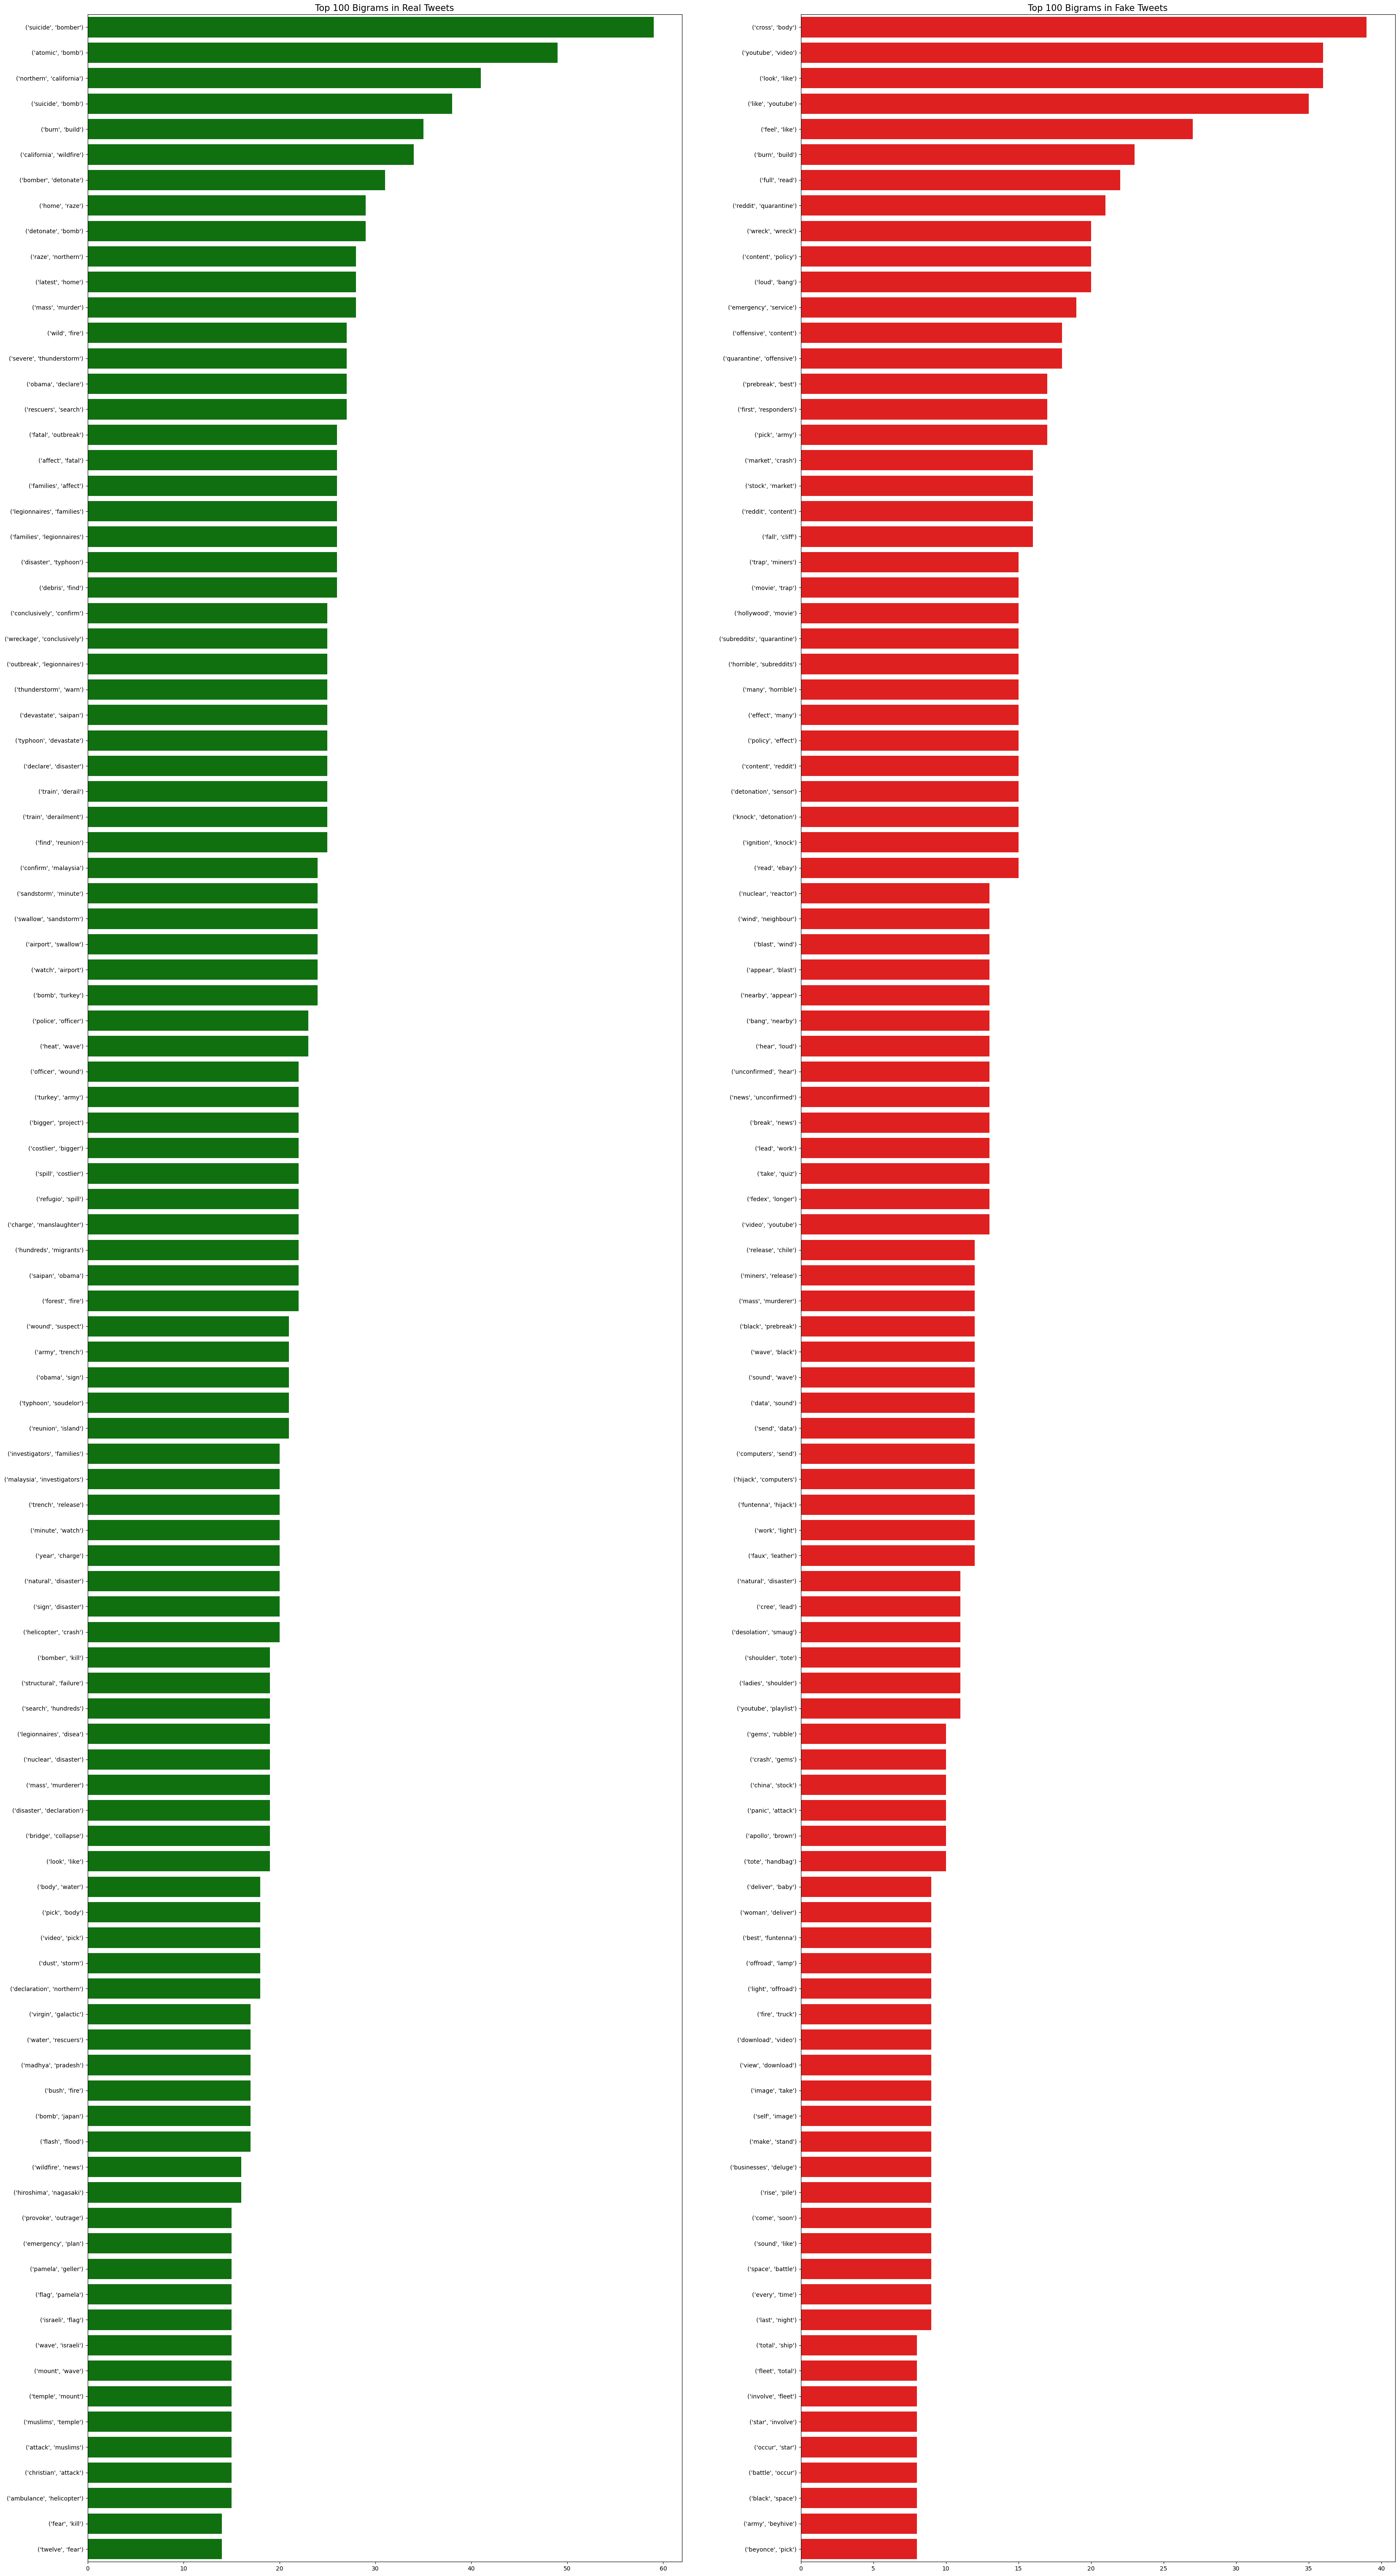

In [ ]:
# lets visualize top 100 bigrams

draw_barplots(real_bigrams,fake_bigrams," Bigrams ")

Trigrams

In [ ]:
real_trigrams = get_ngrams(real,3)
fake_trigrams = get_ngrams(fake,3)

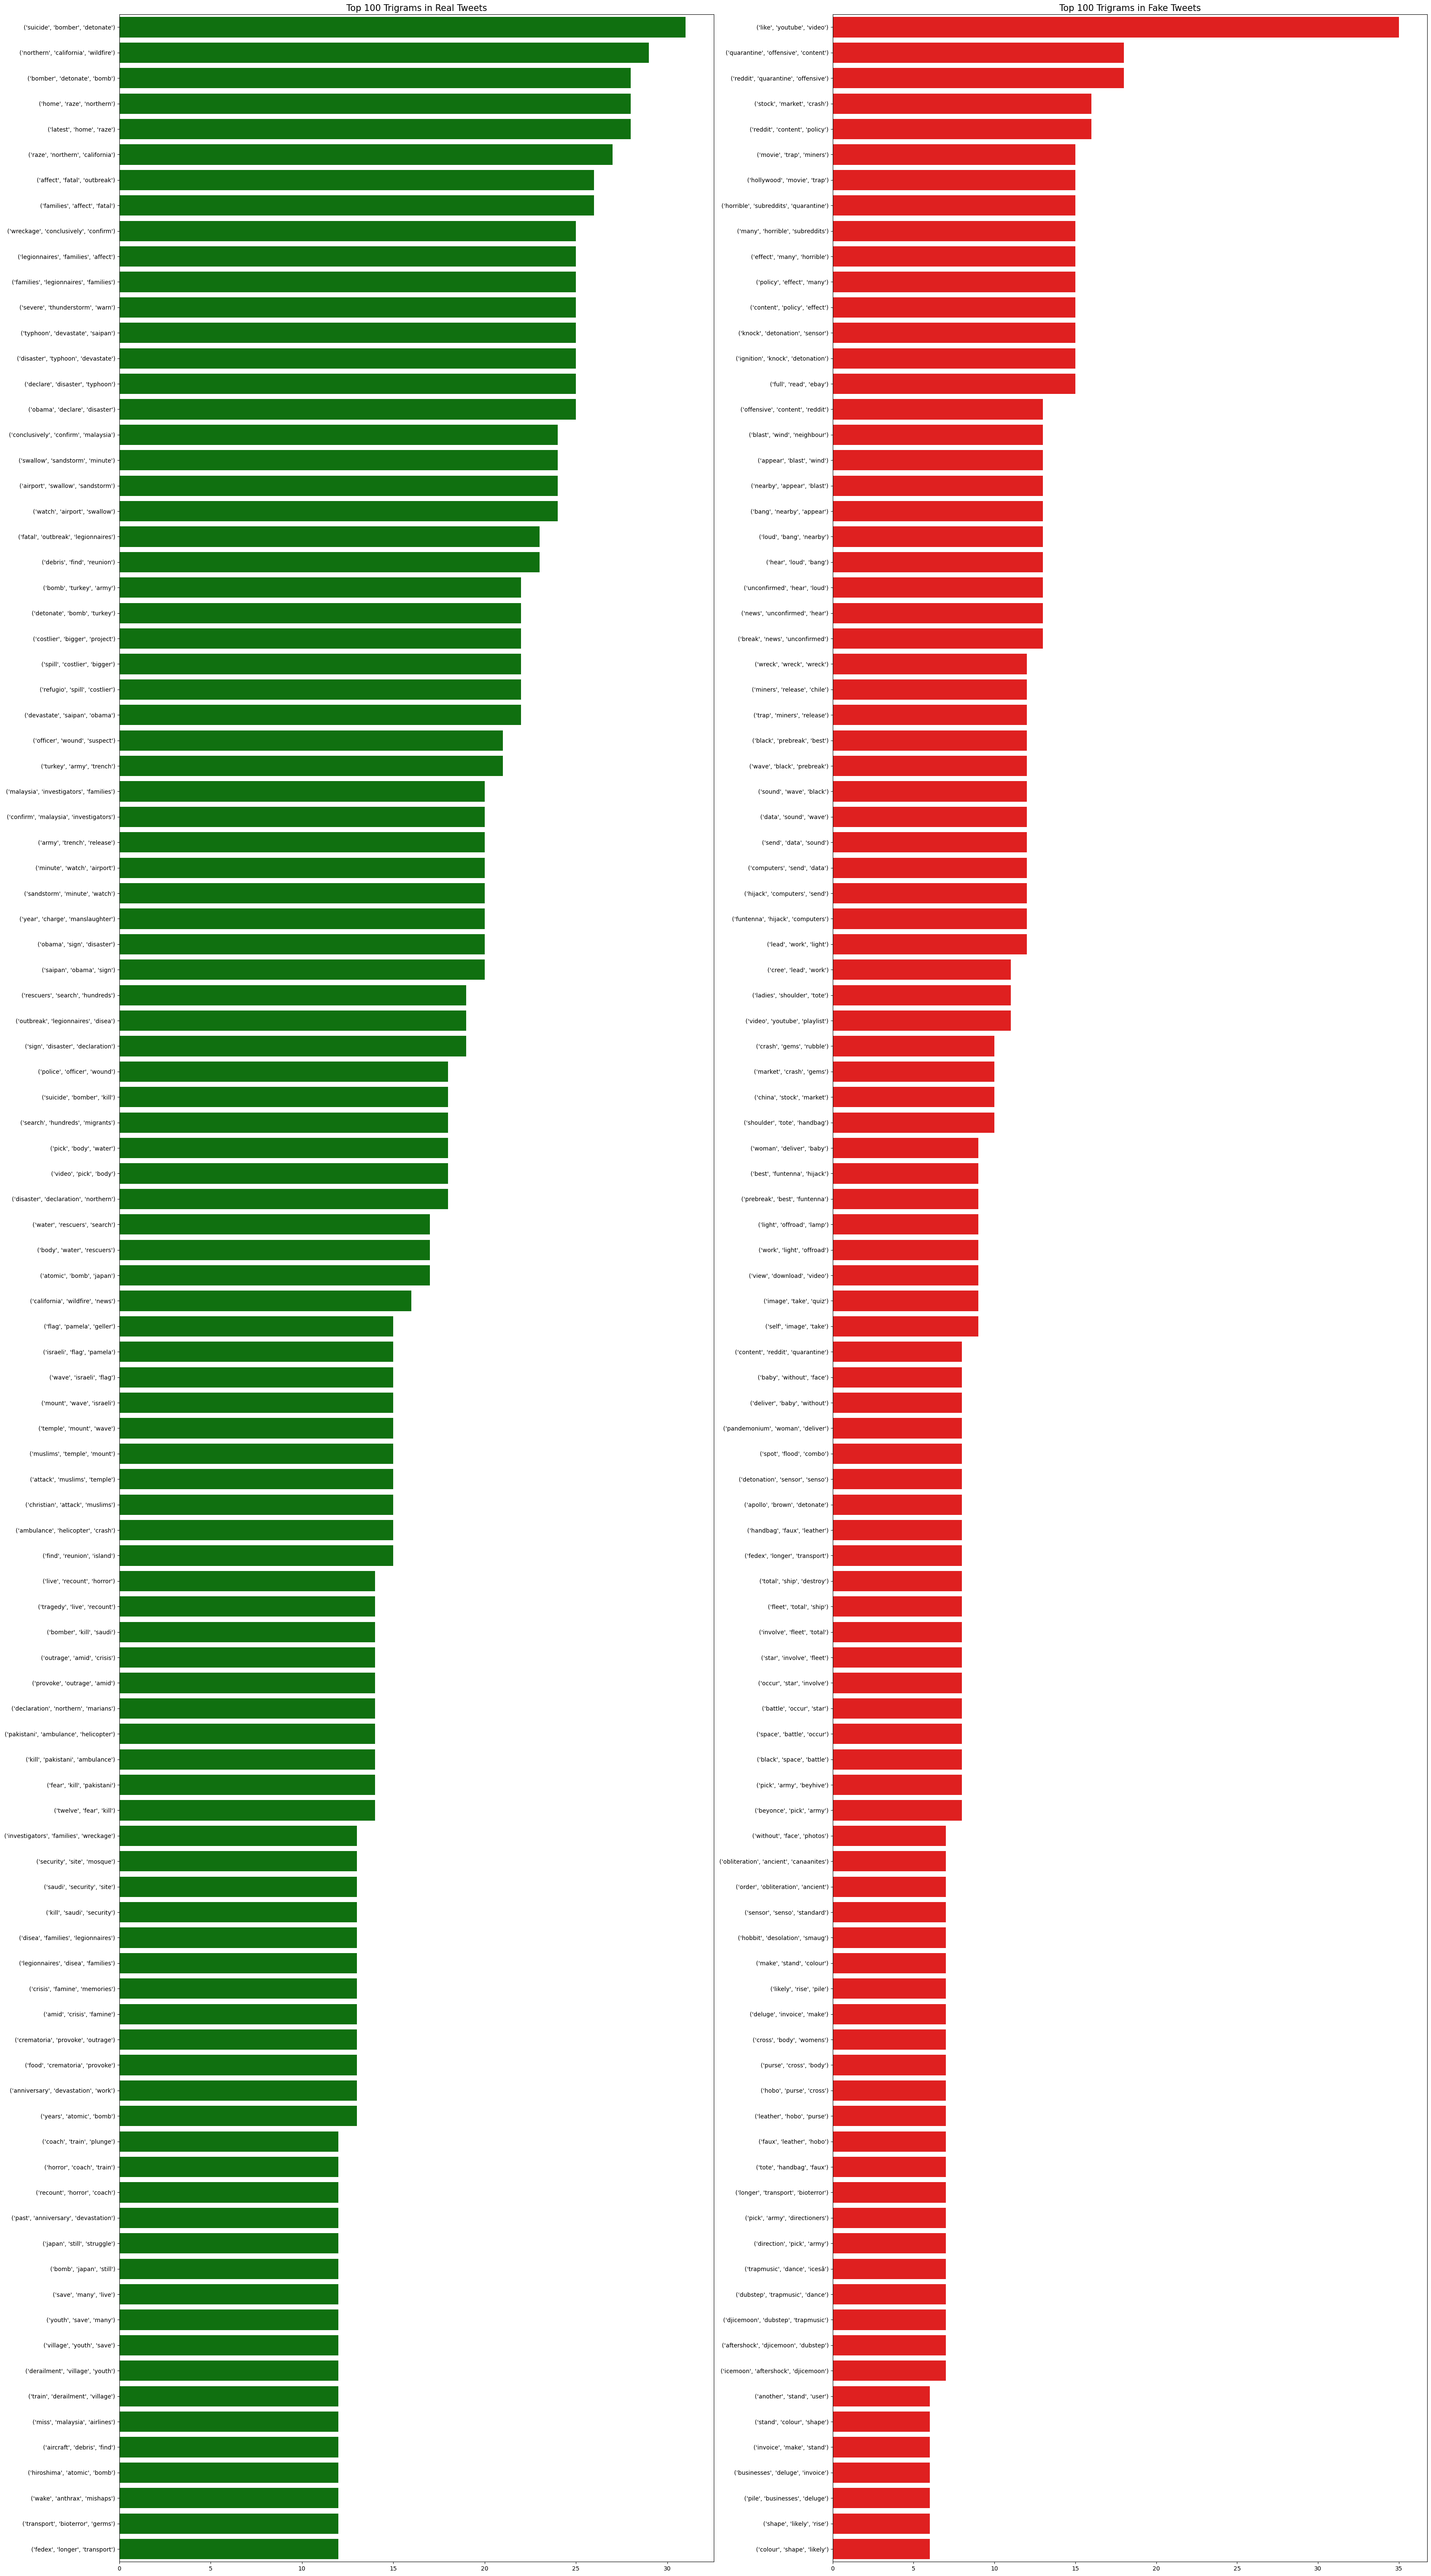

In [ ]:
# lets visualize top 100 trigrams
draw_barplots(real_trigrams,fake_trigrams," Trigrams ")

# **Model Building & Evaluation**

In [ ]:
# function to calculate f1 score for each epoch
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
# Bag of Words model
from keras.preprocessing.text import Tokenizer

# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
# lets use only tweet text to build the model
X = train.text
y = train.target

#test_id = test.id
#test.drop(["id","location","keyword"],1,inplace = True)

In [ ]:
# Test train split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
# create and apply tokenizer on the training dataset
tokenizer = create_tokenizer(X_train)
X_train_set = tokenizer.texts_to_matrix(X_train, mode = 'freq')

In [ ]:
# define the model
def define_model(n_words):
    # define network
    model = Sequential()
    model.add(Dense(128, input_shape=(n_words,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = [get_f1])
    # summarize defined model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [ ]:
# create the model
n_words = X_train_set.shape[1]
model = define_model(n_words)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               863360    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 863,489
Trainable params: 863,489
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#fit network
model.fit(X_train_set,y_train,epochs=10,verbose=2)

Epoch 1/10
191/191 - 2s - loss: 0.6251 - get_f1: 0.3176 - 2s/epoch - 11ms/step
Epoch 2/10
191/191 - 1s - loss: 0.4576 - get_f1: 0.7497 - 978ms/epoch - 5ms/step
Epoch 3/10
191/191 - 1s - loss: 0.3655 - get_f1: 0.8106 - 981ms/epoch - 5ms/step
Epoch 4/10
191/191 - 1s - loss: 0.3097 - get_f1: 0.8442 - 1s/epoch - 7ms/step
Epoch 5/10
191/191 - 2s - loss: 0.2700 - get_f1: 0.8674 - 2s/epoch - 8ms/step
Epoch 6/10
191/191 - 1s - loss: 0.2382 - get_f1: 0.8873 - 1s/epoch - 6ms/step
Epoch 7/10
191/191 - 1s - loss: 0.2119 - get_f1: 0.9036 - 984ms/epoch - 5ms/step
Epoch 8/10
191/191 - 1s - loss: 0.1899 - get_f1: 0.9143 - 1s/epoch - 5ms/step
Epoch 9/10
191/191 - 1s - loss: 0.1718 - get_f1: 0.9241 - 973ms/epoch - 5ms/step
Epoch 10/10
191/191 - 1s - loss: 0.1551 - get_f1: 0.9345 - 997ms/epoch - 5ms/step


# **GLOVE with KERAS Word Embeddings**

In [ ]:
#Fitting a tokenizer on text will create a list of unique words with an integer assigned to it
t = Tokenizer()
t.fit_on_texts(X_train.tolist())

In [ ]:
# lets save the size of the vocab
vocab_size = len(t.word_index) + 1

In [ ]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('/content/glove.6B.100d.txt', mode='rt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 9786 word vectors.


In [ ]:
# we will now perform the encoding
encoded_docs = t.texts_to_sequences(X_train.tolist())

# embedding layer require all the encoded sequences to be of the same length, lets take max lenght as 100
# and apply padding on the sequences which are of lower size
max_length = 100
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[   6 2666    5 ...    0    0    0]
 [ 626    2 1525 ...    0    0    0]
 [ 591 2668    4 ...    0    0    0]
 ...
 [ 349 3757    6 ...    0    0    0]
 [ 561  141    2 ...    0    0    0]
 [   7 1901    4 ...    0    0    0]]


In [ ]:
# create a weight matrix for words in training docs
mis_spelled = []
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        mis_spelled.append(word)

In [ ]:
# lets check how many words are not spelled correctly 
len(mis_spelled)

2728

In [ ]:
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=100, trainable=False)
model.add(e)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[get_f1])
# summarize the model
model.summary()
# fit the model
model.fit(padded_docs, y_train, epochs=10, verbose=0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          674400    
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 684,401
Trainable params: 10,001
Non-trainable params: 674,400
_________________________________________________________________


In [ ]:
loss, accuracy = model.evaluate(padded_docs,y_train,verbose=1)

191/191 [==============================] - 0s 2ms/step - loss: 0.3612 - get_f1: 0.8077


In [ ]:
print(accuracy)

0.8076843619346619


# **CNN with word Embeddings**

In [ ]:
max_length = max([len(s) for s in train.text])
print('Maximum length: %d' % max_length)

Maximum length: 145


In [ ]:
# we will now perform the encoding
encoded_docs = t.texts_to_sequences(X_train.tolist())

# embedding layer require all the encoded sequences to be of the same length, lets take max lenght as 100
# and apply padding on the sequences which are of lower size

padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[   6 2666    5 ...    0    0    0]
 [ 626    2 1525 ...    0    0    0]
 [ 591 2668    4 ...    0    0    0]
 ...
 [ 349 3757    6 ...    0    0    0]
 [ 561  141    2 ...    0    0    0]
 [   7 1901    4 ...    0    0    0]]


In [ ]:
# define vocabulary size
#  we laready have vocab size
vocab_size

6744

In [ ]:
# define the model
def define_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_length))
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize defined model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [ ]:
# define model
model = define_model(vocab_size, max_length)
# fit network
model.fit(padded_docs, y_train, epochs=2, verbose=0)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 145, 100)          674400    
                                                                 
 conv1d (Conv1D)             (None, 138, 32)           25632     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 69, 32)           0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 2208)              0         
                                                                 
 dense_3 (Dense)             (None, 10)                22090     
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                      

In [ ]:
loss, accuracy = model.evaluate(padded_docs, y_train, verbose=0)

In [ ]:
print(accuracy)

0.9103448390960693


# **Multi Channel n-gram CNN Model**

In [ ]:
from keras.layers import Input
from keras.layers import concatenate
from keras.models import Model
# define the model 
def define_model(length, vocab_size): 
    # channel 1 
    inputs1 = Input(shape=(length,)) 
    embedding1 = Embedding(vocab_size, 100)(inputs1) 
    conv1 = Conv1D(32, 4, activation='relu')(embedding1) 
    drop1 = Dropout(0.5)(conv1) 
    pool1 = MaxPooling1D()(drop1) 
    flat1 = Flatten()(pool1)
    
    # channel 2 
    inputs2 = Input(shape=(length,)) 
    embedding2 = Embedding(vocab_size, 100)(inputs2) 
    conv2 = Conv1D(32, 6, activation='relu')(embedding2) 
    drop2 = Dropout(0.5)(conv2) 
    pool2 = MaxPooling1D()(drop2) 
    flat2 = Flatten()(pool2) 
    
    # channel 3 
    inputs3 = Input(shape=(length,)) 
    embedding3 = Embedding(vocab_size, 100)(inputs3) 
    conv3 = Conv1D(32, 8, activation='relu')(embedding3) 
    drop3 = Dropout(0.5)(conv3) 
    pool3 = MaxPooling1D()(drop3) 
    flat3 = Flatten()(pool3)
    
    # merge 
    merged = concatenate([flat1, flat2, flat3]) 
    # interpretation 
    dense1 = Dense(10, activation='relu')(merged) 
    outputs = Dense(1, activation='sigmoid')(dense1) 
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs) 
    # compile 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
    # summarize 
    model.summary() 
    plot_model(model, show_shapes=True, to_file='multichannel.png') 
    return model

In [ ]:
# we will now perform the encoding
encoded_docs = t.texts_to_sequences(X_train.tolist())

# embedding layer require all the encoded sequences to be of the same length, lets take max lenght as 100
# and apply padding on the sequences which are of lower size

padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [ ]:
# define model
model = define_model(max_length,vocab_size)
# fit network
model.fit([padded_docs,padded_docs,padded_docs], array(y_train), epochs=7, batch_size=16)
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 145)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 145)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 145)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 145, 100)     674400      ['input_1[0][0]']                
                                                                                              

In [ ]:
loss, accuracy = model.evaluate([padded_docs,padded_docs,padded_docs], y_train, verbose=0)

In [ ]:
print(accuracy)

0.9694581031799316


# **NAVIES BAYES**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB

In [ ]:
df = pd.read_csv('/content/train.csv', encoding='latin-1')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [ ]:
df['location'].unique()

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

In [ ]:
df = df.drop(['id', 'keyword', 'location'], axis = 1)

df

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


In [ ]:
X = df['text']
y = df['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25)

X_train.head()

2443    #news Madhya Pradesh Train Derailment: Village...
96      Has an accident changed your life? We will hel...
6276    New item: Pillow Covers ANY SIZE Pillow Cover ...
3588    @ChrisDanielShow Nearly-Fatal Pee in San Franc...
3974    #flood #disaster Burst Water Pipe Floods Apart...
Name: text, dtype: object

In [ ]:
import nltk
nltk.download('stopwords')
tokenizer = RegexpTokenizer(r"\w+") # only select alphanumeric characters
en_stop = set(stopwords.words('english')) # get all the English language stopwords
ps = PorterStemmer() # to extract stem out of any given word

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def getStemmedTweet(tweet):
    """
        This function takes the tweet string and then performs the preprocessing steps on it
        to return the cleaned tweet which will be more effective in predictions later made by the 
        classifier.
    """
    tweet = tweet.lower()
    
    tokens = tokenizer.tokenize(tweet)
    new_tokens = [token for token in tokens if token not in en_stop]
    stemmed_tokens = [ps.stem(token) for token in new_tokens]
    
    cleaned_review = ' '.join(stemmed_tokens)
    
    return cleaned_review

In [ ]:
# Apply the preprocessing pipeline function on the whole dataset
X_cleaned = X_train.apply(getStemmedTweet)
Xval_cleaned = X_val.apply(getStemmedTweet)

In [ ]:
## First of all though, we'll need to convert our data into a count vector to be able 
## to work with the Multinomial Naive Bayes model

cv = CountVectorizer()

X_vec = cv.fit_transform(X_cleaned).toarray()
Xval_vec = cv.transform(Xval_cleaned).toarray()

print(X_vec.shape)
print(Xval_vec.shape)

(5709, 15304)
(1904, 15304)


In [ ]:
# Train the classifier

mnb = MultinomialNB()
mnb.fit(X_vec, y_train)

MultinomialNB()

In [ ]:
mnb.score(Xval_vec, y_val)

0.7925420168067226

# **BERT ANALYSIS**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
%matplotlib inline
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('/content/train.csv', encoding='latin-1')
test_df = pd.read_csv('/content/test.csv', encoding='latin-1')
df.shape,test_df.shape

((7613, 5), (3263, 4))

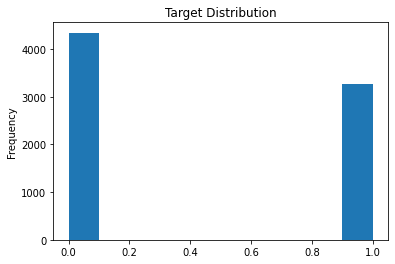

In [ ]:
df['target'].plot(kind='hist',title='Target Distribution')

In [ ]:
df.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [ ]:
df.target.head(15).values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
df.text.head(15).values

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       '13,000 people receive #wildfires evacuation orders in California ',
       'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ',
       '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires',
       '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',
       "I'm on top of the hill and I can see a fire in the woods...",
       "There's an emergency evacuation happening now in the building across the street",
       "I'm afraid that the tornado is coming to our area...",
       'Three people died from the heat wave so far',
       'Haha South Tampa is getting flooded hah-

In [ ]:
train_df,valid_df = train_test_split(df,random_state=42,test_size=0.25)
train_df.shape,valid_df.shape

((5709, 5), (1904, 5))

In [ ]:
module_url1 = "https://tfhub.dev/google/universal-sentence-encoder-large/5"

In [ ]:
def train_and_evaluate_model(module_url1,embed_size1,name,trainable=False):
    hub_layer = hub.KerasLayer(module_url1,input_shape=[],output_shape=[embed_size1],dtype=tf.string,trainable=trainable) 
    model = tf.keras.models.Sequential([
        hub_layer,
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64,activation='relu'),
        tf.keras.layers.Dense(64,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=tf.losses.BinaryCrossentropy(),metrics=[tf.metrics.BinaryAccuracy(name='accuracy')])
    history = model.fit(train_df['text'],train_df['target'],epochs=3,batch_size=32,validation_data=(valid_df['text'],valid_df['target']))
    return model,history

In [ ]:
model,history = train_and_evaluate_model(module_url1,512,'Model1',True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               147354880 
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 256)              

179/179 [==============================] - 481s 2s/step - loss: 0.8203 - accuracy: 0.6322 - val_loss: 0.5862 - val_accuracy: 0.8120
Epoch 2/3
179/179 [==============================] - 409s 2s/step - loss: 0.5727 - accuracy: 0.7611 - val_loss: 0.4539 - val_accuracy: 0.8204
Epoch 3/3
179/179 [==============================] - 402s 2s/step - loss: 0.4972 - accuracy: 0.8087 - val_loss: 0.3969 - val_accuracy: 0.8335
